In [ ]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering



In [56]:
# lectura
df = pd.read_csv("../data/silver/master_table.csv")
df["fecha_efectiva"] = pd.to_datetime(
    df["fecha_efectiva"], format="%Y-%m-%d", errors="coerce"
)

# Agregacion clase-cliente-valor
agg = (
    df
    .groupby(["Id_cliente", "clase"])["valor"]
    .agg(num_tx="count", total_valor="sum")
    .reset_index()
)

# columnas por clase - pivotea para tener fila un cliente + toda su info
pivot = (
    agg
    .pivot(index="Id_cliente", columns="clase", values=["num_tx", "total_valor"])
    .fillna(0)
)
pivot.columns = ["_".join(col).lower() for col in pivot.columns] # une con_
pivot.index.name = "Id_cliente"
pivot.head() # veamos lo que llevamos

,num_tx_avance,num_tx_compra,num_tx_seguro,total_valor_avance,total_valor_compra,total_valor_seguro
Id_cliente,,,,,,
91,1.0,0.0,0.0,500000.0,0.00,0.0
92,2.0,0.0,0.0,400000.0,0.00,0.0
94,0.0,4.0,0.0,0.0,1599018.00,0.0
95,1.0,1.0,0.0,100000.0,1272555.00,0.0
96,0.0,7.0,0.0,0.0,4037771.29,0.0


In [57]:

# Ratio avance/compra - Que tanto genera un cliente en avances comparado con compras
pivot["ratio_avance_compra"] = (
    pivot["total_valor_avance"] / (pivot["total_valor_compra"] + 1) # se pierde el uso de 1 para evitar division por cero - Identifica clientes con comportamientos financieros riesgosos, ya que quienes usan más "avance" que "compra" podrían estar endeudándose más.
)

# Dias ultima transaccion - Medida de recencia, la cantidad de días desde la última transacción
last_tx = df.groupby("Id_cliente")["fecha_efectiva"].max()              # ultima fecha client
overall_latest = df["fecha_efectiva"].max()                             # mas reciente del dataset
recencia = (overall_latest - last_tx).dt.days.rename("dias_desde_ultima_tx") # recencia - metrica de tiempo desde la ultima transaccion, cuantifica uso de la plataforma
pivot = pivot.join(recencia, how="left")

# trans x cliente
total_tx = df.groupby("Id_cliente")["valor"].count().rename("num_transacciones")
pivot["num_transacciones"] = total_tx

# nan recendica - estaba teniendo errores :( entonces por siaca, como minimo deberia ser vero 0 algo numerico
print("NaN en dias_desde_ultima_tx:", pivot["dias_desde_ultima_tx"].isnull().sum())

pivot.head()  # ste vendria seidno mi DF final

NaN en dias_desde_ultima_tx: 0


,num_tx_avance,num_tx_compra,num_tx_seguro,total_valor_avance,total_valor_compra,total_valor_seguro,ratio_avance_compra,dias_desde_ultima_tx,num_transacciones
Id_cliente,,,,,,,,,
91,1.0,0.0,0.0,500000.0,0.00,0.0,500000.000000,27,1
92,2.0,0.0,0.0,400000.0,0.00,0.0,400000.000000,183,2
94,0.0,4.0,0.0,0.0,1599018.00,0.0,0.000000,23,4
95,1.0,1.0,0.0,100000.0,1272555.00,0.0,0.078582,52,2
96,0.0,7.0,0.0,0.0,4037771.29,0.0,0.000000,41,7


# Seleccion de variables

Surge una pregunta importante. ¿Que usar para todo el modelo? Hemos propuesto diferntees features pero , son otdas utiles? En definitiva todo lo relacionado a seguro se descarta por ahora (coumnas de tx_seguro y total_valor_seguri) puesto que serian columnas de ceros. Y algunas columnas ya capturan la informacion de las demas features, por ejemplo avance y compra a se encuentra mapeada con `num_transacciones` + `ratio_avance_compra`. Con esto en mente debemos de seleccionar para el modelado a     "num_transacciones", "total_valor_compra", "total_valor_avance", "ratio_avance_compra" y "dias_desde_ultima_tx"

In [ ]:
features = pivot[[
    "num_transacciones",
    "total_valor_compra",
    "total_valor_avance",
    "ratio_avance_compra",
    "dias_desde_ultima_tx"
]]


In [70]:
features

,num_transacciones,total_valor_compra,total_valor_avance,ratio_avance_compra,dias_desde_ultima_tx
Id_cliente,,,,,
91,1,0.00,500000.0,500000.000000,27
92,2,0.00,400000.0,400000.000000,183
94,4,1599018.00,0.0,0.000000,23
95,2,1272555.00,100000.0,0.078582,52
96,7,4037771.29,0.0,0.000000,41
...,...,...,...,...,...
157,2,129557.00,600000.0,4.631130,30
158,6,973170.00,800000.0,0.822055,37
159,2,300000.00,800000.0,2.666658,120




# Escalado

En general, para evitar ruido ocasionado por la escala numerica, se ha de aplicar un metodo de scaling a los datos. No nos copmpliquemos mucho, imputar la mediana y el standardscaler nos bastará por ahora. Si hay problemas aplicamos transfomraciones logaritmicas (Que ya de vio mejoran normalidad) y demas. Mienrtas, relajados. 


In [ ]:
# Imputacizin mediana por si hubiera valores extremos/missing
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(features)

# SdantardScaler (asume noralidad previa por la forma de este scaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


# Model selection

Como buen cientifico de datos, primero probemos lo mas simple y sencillo. Si nos funciona bien, miramos hasta donde nos llega la curiosidad 100tifika. esto implica que, un primer algoritmo como K-means sera mas que suficiente para un priomer avance.

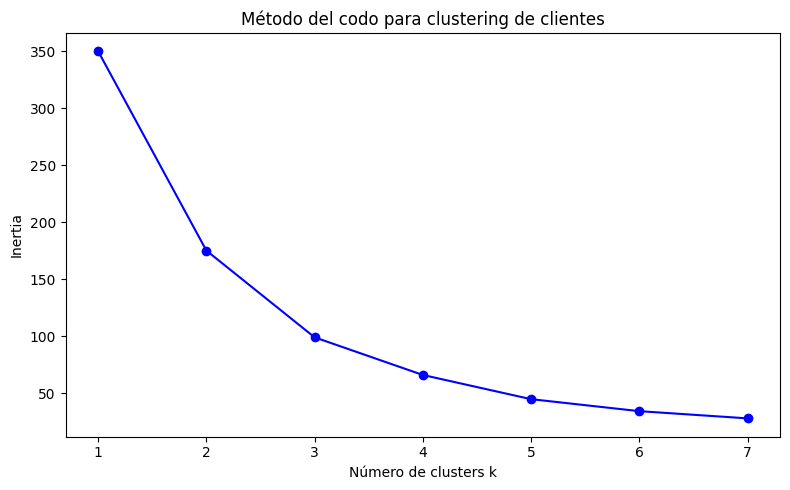

In [60]:

# K-means
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Grafico del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, "bo-")
plt.xlabel("Número de clusters k")
plt.ylabel("Inertia")
plt.title("Método del codo para clustering de clientes")
plt.xticks(K)
plt.tight_layout()
plt.show()


Codo en 3 AKA 3 clusters

In [71]:
pivot

,num_tx_avance,num_tx_compra,num_tx_seguro,total_valor_avance,total_valor_compra,total_valor_seguro,ratio_avance_compra,dias_desde_ultima_tx,num_transacciones,cluster
Id_cliente,,,,,,,,,,
91,1.0,0.0,0.0,500000.0,0.00,0.0,500000.000000,27,1,2
92,2.0,0.0,0.0,400000.0,0.00,0.0,400000.000000,183,2,2
94,0.0,4.0,0.0,0.0,1599018.00,0.0,0.000000,23,4,1
95,1.0,1.0,0.0,100000.0,1272555.00,0.0,0.078582,52,2,1
96,0.0,7.0,0.0,0.0,4037771.29,0.0,0.000000,41,7,1
...,...,...,...,...,...,...,...,...,...,...
157,1.0,1.0,0.0,600000.0,129557.00,0.0,4.631130,30,2,1
158,1.0,5.0,0.0,800000.0,973170.00,0.0,0.822055,37,6,1
159,1.0,1.0,0.0,800000.0,300000.00,0.0,2.666658,120,2,1


In [62]:
# Ajuste del modelo
kmeans = KMeans(n_clusters=3, random_state=1998, n_init=10)
pivot["cluster"] = kmeans.fit_predict(X_scaled)

# Tamaño x cluster
print("Clientes por cluster:")
print(pivot["cluster"].value_counts(), "\n")


Clientes por cluster:
cluster
1    40
0    28
2     2
Name: count, dtype: int64 



Hay 3 cluster en los datos. Encuentra 3 tipos de clientes. Llama la atencion el cluster tan pequeño, se ha de revisar que caracteristicas tienen los clientes del cluster 2 para mirar que tenga sentido. 

In [63]:

# 3. volviendo a escala original
centroids = scaler.inverse_transform(kmeans.cluster_centers_) 
centroids_df = pd.DataFrame(
    centroids,
    columns=features.columns,
    index=[f"cluster_{i}" for i in range(3)]
)
print("Centroides de cada cluster:")
print(centroids_df, "\n")


Centroides de cada cluster:
           num_transacciones  total_valor_compra  total_valor_avance  \
cluster_0          92.821429        2.616444e+07        8.985714e+06   
cluster_1          17.000000        4.471107e+06        1.610325e+06   
cluster_2           1.500000       -1.862645e-09        4.500000e+05   

           ratio_avance_compra  dias_desde_ultima_tx  
cluster_0             0.374139                   3.5  
cluster_1             0.754061                  33.8  
cluster_2        450000.000000                 105.0   



Por definicion **ratio_avance_compra** es la division del avance entre el total valor de la compra. Pero ojo *si el valor de la compra es casi cero* entonces esto será un numero muy grande. 

Los clientes del **cluster 2** tienen practicametne 0 en su valor de compra. Dicho de otra manera, **estos son los clietnes a los cuales ofrecerle un 25% de descuento** puesto que son personas con un solo avances y sin compras. 

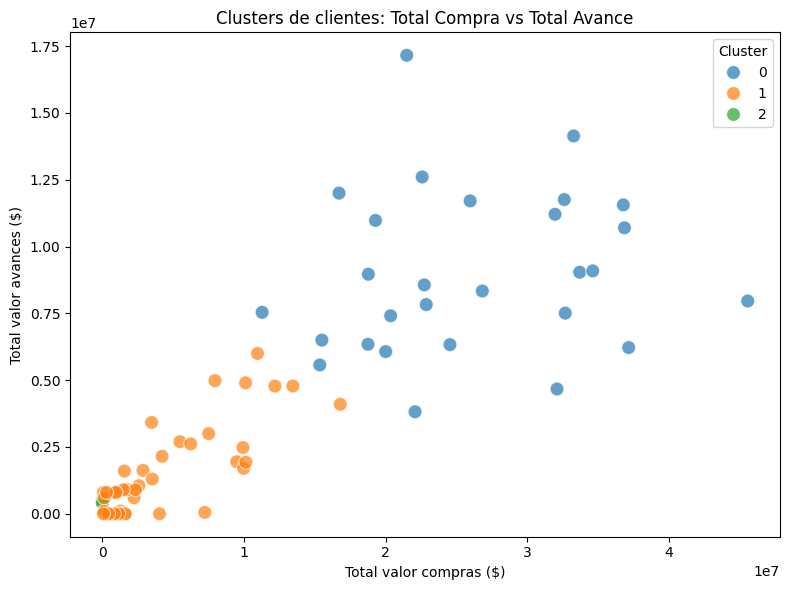

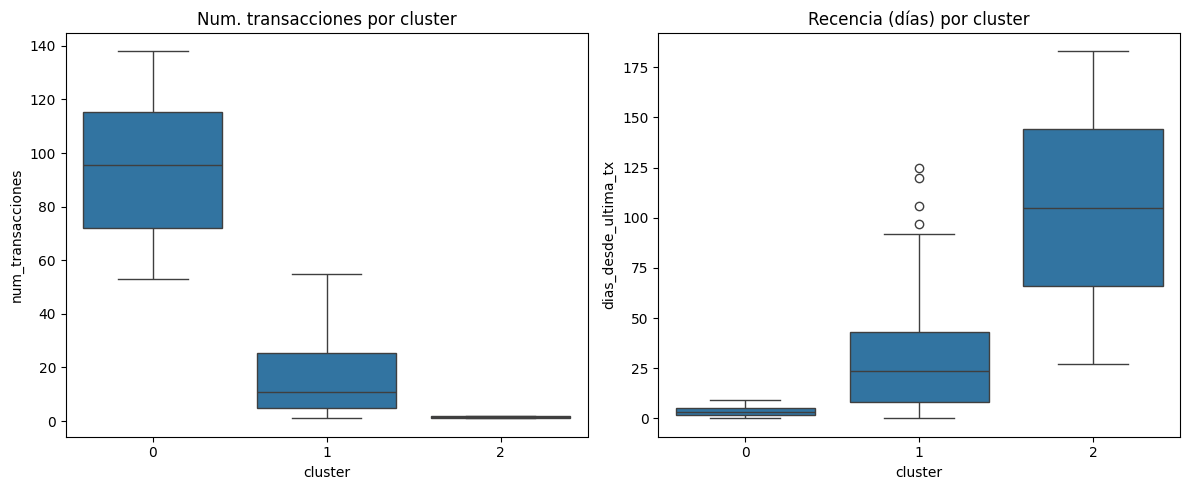

In [65]:
# Graficos 
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pivot,
    x="total_valor_compra",
    y="total_valor_avance",
    hue="cluster",
    palette="tab10",
    s=100,
    alpha=0.7
)
plt.title("Clusters de clientes: Total Compra vs Total Avance")
plt.xlabel("Total valor compras ($)")
plt.ylabel("Total valor avances ($)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 5. Boxplot de recencia y transacciones por cluster
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(x="cluster", y="num_transacciones", data=pivot, ax=axes[0])
axes[0].set_title("Num. transacciones por cluster")
sns.boxplot(x="cluster", y="dias_desde_ultima_tx", data=pivot, ax=axes[1])
axes[1].set_title("Recencia (días) por cluster")
plt.tight_layout()
plt.show()


En general, los clusters se ven muy marcados y diferenciados. Destaca el cluser 2 que presenta alfgunos valores extraños. Analicemos (obviando que claramente, hay diferencia significatia entre losc luster encontrados)



# Metricas para clusering - kmeans

In [38]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# X_scaled es tu matriz escalada y kmeans tu modelo ajustado
labels = kmeans.labels_

sil = silhouette_score(X_scaled, labels)
ch  = calinski_harabasz_score(X_scaled, labels)
db  = davies_bouldin_score(X_scaled, labels)

print(f"Silhouette Score       : {sil:.3f}")
print(f"Calinski-Harabasz Index: {ch:.1f}")
print(f"Davies-Bouldin Index   : {db:.3f}")


Silhouette Score       : 0.537
Calinski-Harabasz Index: 84.7
Davies-Bouldin Index   : 0.604


**Inisghts**

 1. Buen coeficiente de silueta, clusters bien delimitados (mayor a 0.5)
 2. Davies-Bouldin - (0.6 <1), lo que indica fuerza en la separacion
 3. Calinsky - 84.7; not great not terrible. Como decia mi ex, los he visto mas grandes.

# Comparando con otros modelos 

Por la curiosidad cientifica, miremos si hay mejor rendimiendo con otros modelos. 

In [66]:

gm = GaussianMixture(n_components=3, random_state=42)
labels_gm = gm.fit_predict(X_scaled)

# Cluser jerarquico
hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_hc = hc.fit_predict(X_scaled)

# Labels de cada cluster
algos = {
    "KMeans": pivot["cluster"].values,
    "GMM":    labels_gm,
    "Hierárquico": labels_hc
}

# emtricas
results = []
for name, labs in algos.items():
    sil = silhouette_score(X_scaled, labs)
    ch  = calinski_harabasz_score(X_scaled, labs)
    db  = davies_bouldin_score(X_scaled, labs)
    results.append((name, sil, ch, db))

# comparativa
comp = pd.DataFrame(results, columns=["Algoritmo","Silhouette","Calinski-Harabasz","Davies-Bouldin"])
print(comp)


     Algoritmo  Silhouette  Calinski-Harabasz  Davies-Bouldin
0       KMeans    0.537202          84.670630        0.603915
1          GMM    0.507661          77.326100        0.630240
2  Hierárquico    0.527166          79.438094        0.601542


Nos quedamos con K-Means


In [68]:

# 3. volviendo a escala original
centroids = scaler.inverse_transform(kmeans.cluster_centers_) 
centroids_df = pd.DataFrame(
    centroids,
    columns=features.columns,
    index=[f"cluster_{i}" for i in range(3)]
)
print("Centroides de cada cluster:")
print(centroids_df, "\n")

Centroides de cada cluster:
           num_transacciones  total_valor_compra  total_valor_avance  \
cluster_0          92.821429        2.616444e+07        8.985714e+06   
cluster_1          17.000000        4.471107e+06        1.610325e+06   
cluster_2           1.500000       -1.862645e-09        4.500000e+05   

           ratio_avance_compra  dias_desde_ultima_tx  
cluster_0             0.374139                   3.5  
cluster_1             0.754061                  33.8  
cluster_2        450000.000000                 105.0   



# Contruccion estrategia

 1. Cluster 0 - Clientes activos, promedio de 92 transacciones, buen dinero en compras, muy activos en plataforma - > **No se asigna descuento**
 2. Cluster 1 - 17 transacciones en gneral, casi 4.5M en compras, tiempo de uso en plataforma de 34 dias aprox. Este al ser el cluster mas grande (4o clientes) de propone dividirlo en 2, un incentivo pequeño (5%) para **clientes con un ratio > a la mediana del ratio** y **para los que tengan un ratio mas grande, un descuento del 20%**
 3. Cluster 2 - Clientes con pocas transacciones, sin compras, avances hechos y mucho tiempoinactivo en plataforma. A estos clientes "solo avance" se les aigna un **25% de descuento**

In [69]:
pivot

,num_tx_avance,num_tx_compra,num_tx_seguro,total_valor_avance,total_valor_compra,total_valor_seguro,ratio_avance_compra,dias_desde_ultima_tx,num_transacciones,cluster
Id_cliente,,,,,,,,,,
91,1.0,0.0,0.0,500000.0,0.00,0.0,500000.000000,27,1,2
92,2.0,0.0,0.0,400000.0,0.00,0.0,400000.000000,183,2,2
94,0.0,4.0,0.0,0.0,1599018.00,0.0,0.000000,23,4,1
95,1.0,1.0,0.0,100000.0,1272555.00,0.0,0.078582,52,2,1
96,0.0,7.0,0.0,0.0,4037771.29,0.0,0.000000,41,7,1
...,...,...,...,...,...,...,...,...,...,...
157,1.0,1.0,0.0,600000.0,129557.00,0.0,4.631130,30,2,1
158,1.0,5.0,0.0,800000.0,973170.00,0.0,0.822055,37,6,1
159,1.0,1.0,0.0,800000.0,300000.00,0.0,2.666658,120,2,1


# 